### Notes:
* Tenir en compte la succession de phrases au sein d'un même commentaires (peut-être avec l'architecture type A / B) pour prendre en compte les coréférences.

In [1]:
import csv
import os
import pandas as pd
import logging
import argparse
import random
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
import torch.nn as nn

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertForSequenceClassification, BertModel, PreTrainedBertModel, BertConfig
from pytorch_pretrained_bert.optimization import BertAdam
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
sns.set()

In [3]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [4]:
class InputFeatures(object):
    """A single set of features of data."""
    def __init__(self, input_ids, input_mask, segment_ids, label):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label = label

In [5]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, skip_rows=0):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding='utf-8') as f:
            reader = csv.reader(f, delimiter="\t")
            lines = []
            row = 0
            for line in reader:
                if row >= skip_rows:
                    lines.append(line) 
                else:
                    row += 1
    
        return lines

In [6]:
class MultiLabelProcessor(DataProcessor):
    
    def get_train_examples(self, data_dir, skip_rows=0):
        """See base class."""
        return self._create_examples(self._read_tsv(data_dir, skip_rows), "train")
    
    def get_dev_examples(self, data_dir, skip_rows=0):
        """See base class."""
        return self._create_examples(self._read_tsv(data_dir, skip_rows), "valid")  
    
    def get_test_examples(self, data_dir, skip_rows=0):
        """See base class."""
        return self._create_examples(self._read_tsv(data_dir, skip_rows), "test")
    def get_labels(self):
        """See base class."""
        raise NotImplementedError

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            label = eval(line[2])
            text_a = line[1]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [7]:
def convert_examples_to_features(examples, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""
    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)
        tokens_b = None
        
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label = example.label
        if ex_index < 5:
            print("*** Example ***")
            print("guid: %s" % (example.guid))
            print("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            print("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            print("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            print(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            print("label: %s" % (example.label))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label=label))
    return features


In [8]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(btokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [9]:
def accuracy(out, labels):
    # TODO: "==" deprecated
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

def warmup_linear(x, warmup=0.002):
    if x < warmup:
        return x/warmup
    return 1.0 - x

## Create model

In [10]:
# Set up calculations on GPU
device = torch.device("cuda")

In [11]:
# Some parameters
gradient_accumulation_steps = 1 # Number of updates steps to accumulate before performing a backward/update pass.
bert_config = "bert-base-multilingual-cased"
data_dir = ""
output_dir = ""
max_seq_length = 60
train_batch_size = 32
eval_batch_size = 8
learning_rate = 5e-5 # initial learning rate for Adam
num_train_epochs = 3
warmup_proportion = 0.1 # for linear learning rate warmup
num_labels = 13

In [12]:
tokenizer = BertTokenizer.from_pretrained(bert_config)

In [13]:
class BertForMultiLabelClassification(PreTrainedBertModel):
    
    def __init__(self, config, num_labels=2):
        
        super(BertForMultiLabelClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        self.outputs = nn.Sigmoid()
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        # logits = self.outputs(logits)

        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss
        else:
            return self.outputs(logits)
        
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True


In [14]:
model = BertForMultiLabelClassification.from_pretrained(bert_config, cache_dir= PYTORCH_PRETRAINED_BERT_CACHE / 'distributed_-1', num_labels = num_labels)

In [15]:
# Optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
# layers with weight_decay i.e. regularization L2
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [16]:
optimizer = BertAdam(optimizer_grouped_parameters,
                    lr=learning_rate,
                    warmup=warmup_proportion,
                     t_total=num_train_epochs)

## Load data for classifier

In [17]:
df_train = pd.read_csv('../data/sentences_reviews_train.csv', sep='|', header=None)
df_train.to_csv('../data/sentences_reviews_train.tsv', sep='\t')
df_valid = pd.read_csv('../data/sentences_reviews_valid.csv', sep='|', header=None)
df_valid.to_csv('../data/sentences_reviews_valid.tsv', sep='\t')

In [18]:
df_train.head()

,0,1
0,Judging from previous posts this used to be a ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
1,"We, there were four of us, arrived at noon - t...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
2,"They never brought us complimentary noodles, i...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
3,The food was lousy - too sweet or too salty an...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"After all that, they complained to me about th...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [19]:
df_valid.head()

,0,1
0,"never swaying, never a bad meal, never bad ser...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]"
1,I'm telling you...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
2,you should travel from the Bronx to try it...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
3,"great food, great wine list, great service in ...","[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]"
4,so delicious!!!!!!,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [20]:
# Proportion of labels in train set
np.stack(df_train[1].apply(eval).values).sum(axis=0)

array([ 65, 564, 108,  17,  40,  26, 306, 195,  25, 345,  54,  80, 214])

In [21]:
# Proportion of labels in valid set
np.stack(df_valid[1].apply(eval).values).sum(axis=0)

array([ 17, 117,  20,   3,   6,   4, 113,  31,   3,  76,  26,  17,  78])

In [22]:
processor = MultiLabelProcessor()
train_examples = processor.get_train_examples('../data/sentences_reviews_train.tsv', skip_rows=1)

In [23]:
featured_train_examples = convert_examples_to_features(train_examples, max_seq_length=60, tokenizer=tokenizer)

*** Example ***
guid: train-0
tokens: [CLS] ju ##d ##ging from previous posts this used to be a good place , but not any longer . [SEP]
input_ids: 101 23005 10162 13808 10188 16741 68699 10531 11031 10114 10347 169 15198 11192 117 10473 10472 11178 20165 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
*** Example ***
guid: train-1
tokens: [CLS] we , there were four of us , arrived at no ##on - the place was empty - and the staff acted like we were im ##posing on them and they were very rud ##e . [SEP]
input_ids: 101 11951 117 11155 10309 11598 10108 19626 117 22584 10160 10192 10263 118 10105 11192 10134 65042 118 10111 10105 18927 48809 1185

In [24]:
len(featured_train_examples)

1600

In [25]:
valid_examples = processor.get_test_examples('../data/sentences_reviews_valid.tsv', skip_rows=1)

In [26]:
featured_valid_examples = convert_examples_to_features(valid_examples, max_seq_length=60, tokenizer=tokenizer)

*** Example ***
guid: test-0
tokens: [CLS] never s ##way ##ing , never a bad me ##al , never bad service . . . [SEP]
input_ids: 101 14794 187 14132 10230 117 14794 169 15838 10911 10415 117 14794 15838 11989 119 119 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
label: [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
*** Example ***
guid: test-1
tokens: [CLS] i ' m telling you . . . [SEP]
input_ids: 101 177 112 181 61758 13028 119 119 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
segment_ids: 0 0 0 0 0

In [27]:
# Convert to tensors to be used in NN
all_input_ids_train = torch.tensor([f.input_ids for f in featured_train_examples], dtype=torch.long)
all_input_mask_train = torch.tensor([f.input_mask for f in featured_train_examples], dtype=torch.long)
all_segment_ids_train = torch.tensor([f.segment_ids for f in featured_train_examples], dtype=torch.long)
all_labels_train = torch.tensor([f.label for f in featured_train_examples], dtype=torch.float)

In [28]:
train_data = TensorDataset(all_input_ids_train, all_input_mask_train, all_segment_ids_train, all_labels_train)

In [29]:
train_sampler = RandomSampler(train_data)

In [30]:
all_input_ids_valid = torch.tensor([f.input_ids for f in featured_valid_examples], dtype=torch.long)
all_input_mask_valid = torch.tensor([f.input_mask for f in featured_valid_examples], dtype=torch.long)
all_segment_ids_valid = torch.tensor([f.segment_ids for f in featured_valid_examples], dtype=torch.long)
all_labels_valid = torch.tensor([f.label for f in featured_valid_examples], dtype=torch.float)

In [31]:
valid_data = TensorDataset(all_input_ids_valid, all_input_mask_valid, all_segment_ids_valid, all_labels_valid)

In [32]:
valid_sampler = RandomSampler(valid_data)

In [33]:
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=train_batch_size)

## Train model

In [34]:
num_train_steps = int(len(train_examples) / train_batch_size / gradient_accumulation_steps * num_train_epochs)
print(num_train_steps)

150


In [35]:
model = model.to(device)

In [36]:
model = model.train()

In [37]:
torch.cuda.manual_seed_all(42)

In [38]:
t_total = num_train_steps

In [39]:
lr_rates = []

In [40]:
global_step = 0

for _ in trange(int(num_train_epochs), desc="Epoch"):
    
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    for step, batch in enumerate(train_dataloader):
        
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, labels = batch
        
        if step == 0:
            outputs = model(input_ids, segment_ids, input_mask)
            print("outputs[0]:", outputs[0])
            print("labels[0]:", labels[0])
        
        loss = model(input_ids, segment_ids, input_mask, labels)
        loss.backward()

        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        
        if (step + 1) % gradient_accumulation_steps == 0:
            # modify learning rate with special warm up BERT uses
            lr_this_step = learning_rate * warmup_linear(global_step/t_total, warmup_proportion)
            lr_rates.append(lr_this_step)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_this_step
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
            
    print("Epoch:", _, "Loss:", tr_loss / nb_tr_steps)
            

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

outputs[0]: tensor([0.5288, 0.5096, 0.5047, 0.4018, 0.4374, 0.4645, 0.5285, 0.5344, 0.4955,
        0.5305, 0.4660, 0.5177, 0.4907], device='cuda:0',
       grad_fn=<SelectBackward>)
labels[0]: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.], device='cuda:0')


Epoch:  33%|███▎      | 1/3 [00:43<01:27, 43.87s/it]

Epoch: 0 Loss: 16.574214062690736
outputs[0]: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<SelectBackward>)
labels[0]: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.], device='cuda:0')


Epoch:  67%|██████▋   | 2/3 [01:27<00:43, 43.88s/it]

Epoch: 1 Loss: 38.99293050765991
outputs[0]: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SelectBackward>)
labels[0]: tensor([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')


Epoch: 100%|██████████| 3/3 [02:11<00:00, 43.90s/it]

Epoch: 2 Loss: 132.5465224456787


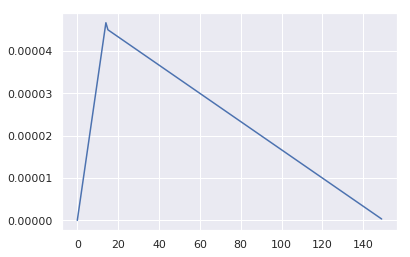

In [41]:
plt.plot(lr_rates)

In [42]:
# Save a trained model
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model itself
num_labels = model.num_labels
output_model_file = os.path.join(output_dir, "pytorch_multilabel.bin")
torch.save(model_to_save.state_dict(), output_model_file)

In [43]:
# Load a trained model that you have fine-tuned
model_state_dict = torch.load(output_model_file)
model = BertForMultiLabelClassification.from_pretrained(bert_config, state_dict=model_state_dict, num_labels=num_labels)
model.to(device)

BertForMultiLabelClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertInte

In [44]:
eval_data = TensorDataset(all_input_ids_valid, all_input_mask_valid, all_segment_ids_valid, all_labels_valid)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)

In [45]:
# Eval a model
model = model.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

results = []
inputs_ids_total = []

for step, batch in enumerate(tqdm(valid_dataloader, desc="Iteration")):
        
#     batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch
    inputs_ids_total += [input_ids.numpy()]

    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        tmp_eval_loss = model(input_ids, segment_ids, input_mask, label_ids)
        logits = model(input_ids, segment_ids, input_mask)

    logits = logits.detach().cpu().numpy()
    label_ids = label_ids.to('cpu').numpy()
    
    results += list(zip(logits, label_ids))
    
    tmp_eval_accuracy = accuracy(logits, label_ids)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += input_ids.size(0)
    nb_eval_steps += 1

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]/home/nicolas_mingione/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
Iteration: 100%|██████████| 13/13 [00:06<00:00,  2.38it/s]


In [46]:
model.state_dict()['classifier.weight']

tensor([[-0.2279, -0.2292, -0.2179,  ..., -0.2314, -0.2158,  0.2263],
        [-0.2436, -0.2711, -0.2364,  ..., -0.2863, -0.2936,  0.2513],
        [-0.1912, -0.2361, -0.1762,  ..., -0.2262, -0.2325,  0.2140],
        ...,
        [-0.2618, -0.2238, -0.2116,  ..., -0.2426, -0.2142,  0.2400],
        [-0.2155, -0.2226, -0.2331,  ..., -0.2451, -0.2030,  0.1853],
        [-0.2296, -0.2695, -0.2147,  ..., -0.2165, -0.2388,  0.2499]],
       device='cuda:0')

In [47]:
eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / nb_eval_examples

result = {'eval_loss': eval_loss,
          'eval_accuracy': eval_accuracy,
          'global_step': global_step,
          'loss': tr_loss/nb_tr_steps}

In [48]:
result["eval_loss"]

153.24996713491586

In [49]:
lin_inputs = [x for z in inputs_ids_total for x in z]

In [50]:
print(tokenizer.convert_ids_to_tokens(lin_inputs[0]))
print(results[1])

['[CLS]', 'help', '##ful', 'service', 'and', 'average', 'price', 'per', 'dis', '##h', '$', '10', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))
